In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 18.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

import optuna

from google.colab import drive


In [ ]:
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/data_sets_classificacao_churn'

X_train_over = pd.read_csv(f"{DATA_DIR}/X_train_over.csv")
y_train_over = pd.read_csv(f"{DATA_DIR}/y_train_over.csv")

X_val_over = pd.read_csv(f"{DATA_DIR}/X_val_over.csv")
y_val_over = pd.read_csv(f"{DATA_DIR}/y_val_over.csv")

X_test = pd.read_csv(f"{DATA_DIR}/X_test.csv")
y_test = pd.read_csv(f"{DATA_DIR}/y_test.csv")

feature_names = X_train_over.columns.tolist()

Mounted at /content/drive


In [ ]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0)
    }

    model = GradientBoostingClassifier(**params)

    model.fit(X_train_over, y_train_over)

    p_val = model.predict_proba(X_val_over)[:, 1]
    auc = roc_auc_score(y_val_over, p_val)

    return auc


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best AUC:", study.best_value)
print("Best params:", study.best_params)


[I 2025-12-18 01:58:22,890] A new study created in memory with name: no-name-548a8343-9851-4496-b5e5-71cd171c94f7
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-12-18 01:58:26,405] Trial 0 finished with value: 0.8486163487133985 and parameters: {'n_estimators': 282, 'learning_rate': 0.07003641045117108, 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.6373690724654959}. Best is trial 0 with value: 0.8486163487133985.
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-12-18 01:58:28,215] Trial 1 finished with value:

Best AUC: 0.850652583812353
Best params: {'n_estimators': 113, 'learning_rate': 0.06209333666601164, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 13, 'subsample': 0.8502854966867661}


In [ ]:
best_params = study.best_params

final_model = GradientBoostingClassifier(**best_params)

# Junta treino + validação
X_train_full = np.vstack([X_train_over, X_val_over])

y_train_full = np.vstack([y_train_over, y_val_over]).ravel()
#                      ↑ empilha linhas
#                                   ↑ transforma em vetor 1D

final_model.fit(X_train_full, y_train_full)


GradientBoostingClassifier(learning_rate=0.06209333666601164, max_depth=2,
                           min_samples_leaf=13, min_samples_split=9,
                           n_estimators=113, subsample=0.8502854966867661)

In [ ]:
def predict_proba_sklearn(model, X, y):
    p = model.predict_proba(X)[:, 1]
    return p, y


In [ ]:
p_train, y_train_true = predict_proba_sklearn(final_model, X_train_over, y_train_over)
p_val,   y_val_true   = predict_proba_sklearn(final_model, X_val_over, y_val_over)
p_test,  y_test_true  = predict_proba_sklearn(final_model, X_test, y_test)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


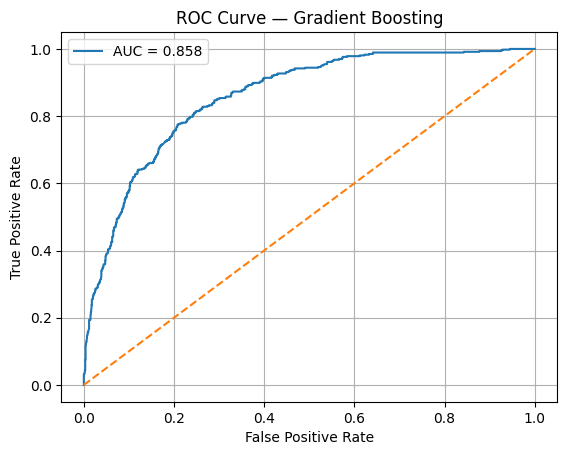

In [ ]:
fpr, tpr, _ = roc_curve(y_test_true, p_test)
auc_score = roc_auc_score(y_test_true, p_test)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Gradient Boosting")
plt.legend()
plt.grid(True)
plt.show()


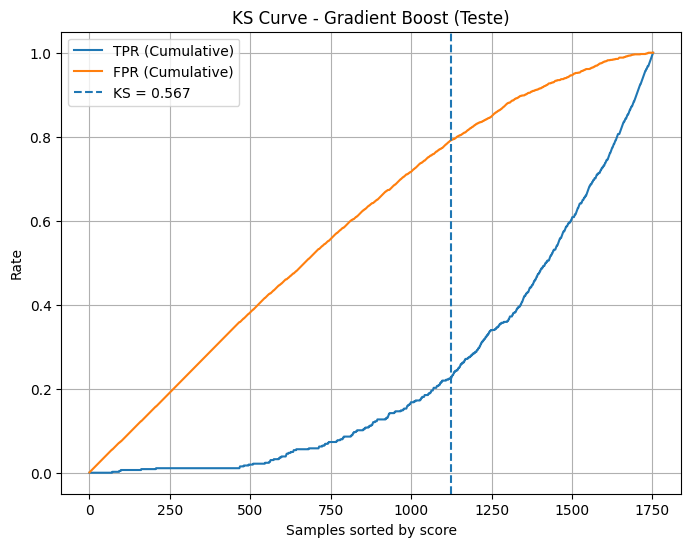

In [ ]:

# garante numpy arrays
p_test = np.asarray(p_test)
y_test_true = np.asarray(y_test_true).ravel()

# ordena pelas probabilidades
order = np.argsort(p_test)
y_sorted = y_test_true[order]

# curvas acumuladas
cum_pos = np.cumsum(y_sorted) / np.sum(y_sorted)
cum_neg = np.cumsum(1 - y_sorted) / np.sum(1 - y_sorted)

# KS
ks_values = np.abs(cum_pos - cum_neg)
ks = np.max(ks_values)
ks_idx = np.argmax(ks_values)

# -------------------
# PLOT
# -------------------
plt.figure(figsize=(8, 6))

plt.plot(cum_pos, label="TPR (Cumulative)")
plt.plot(cum_neg, label="FPR (Cumulative)")

plt.axvline(
    ks_idx,
    linestyle="--",
    label=f"KS = {ks:.3f}"
)

plt.xlabel("Samples sorted by score")
plt.ylabel("Rate")
plt.title("KS Curve - Gradient Boost (Teste)")
plt.legend()
plt.grid(True)

plt.show()


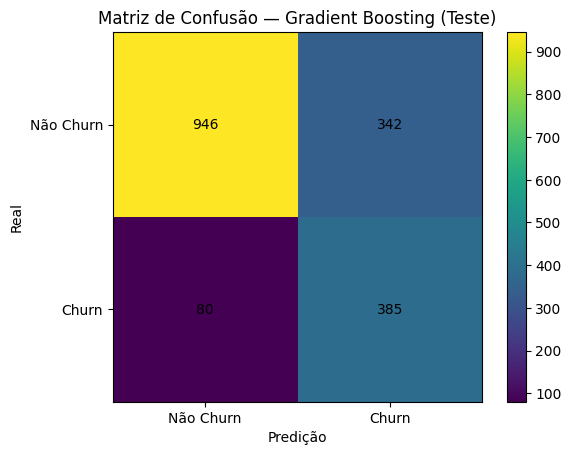

In [ ]:
threshold = 0.5
y_pred = (p_test >= threshold).astype(int)

cm = confusion_matrix(y_test_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.colorbar()
plt.xticks([0, 1], ["Não Churn", "Churn"])
plt.yticks([0, 1], ["Não Churn", "Churn"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("Matriz de Confusão — Gradient Boosting (Teste)")
plt.show()


# Variando parametros com outros fixados

## fixando taxas de aprendizado e variando estrutura

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    confusion_matrix
)
from scipy.stats import ks_2samp


In [ ]:
def ks_statistic(y_true, y_prob):
    y_true = np.asarray(y_true).ravel()
    y_prob = np.asarray(y_prob).ravel()

    return ks_2samp(
        y_prob[y_true == 1],
        y_prob[y_true == 0]
    ).statistic


In [ ]:
def objective_gb_structure(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 200),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),

        # 🔒 FIXOS
        "learning_rate": 0.05,
        "random_state": 42
    }

    model = GradientBoostingClassifier(**params)

    model.fit(X_train_over, y_train_over)

    p_val = model.predict_proba(X_val_over)[:, 1]

    return ks_statistic(y_val_over, p_val)


In [ ]:
study_gb_struct = optuna.create_study(direction="maximize")
study_gb_struct.optimize(objective_gb_structure, n_trials=30)

BEST_GB_STRUCT = study_gb_struct.best_params
print("Melhor estrutura:", BEST_GB_STRUCT)


[I 2025-12-19 03:41:05,395] A new study created in memory with name: no-name-01e32a3b-c3be-4f76-97ea-3fe5dac21610
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-12-19 03:41:07,624] Trial 0 finished with value: 0.562888198757764 and parameters: {'n_estimators': 154, 'max_depth': 4, 'min_samples_leaf': 140, 'subsample': 0.7740457565897245}. Best is trial 0 with value: 0.562888198757764.
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-12-19 03:41:09,749] Trial 1 finished with value: 0.5566770186335404 and parameters: {'n_estimators': 149, 'max_

Melhor estrutura: {'n_estimators': 242, 'max_depth': 4, 'min_samples_leaf': 170, 'subsample': 0.6141740633536202}


In [ ]:
gb_struct = GradientBoostingClassifier(
    **BEST_GB_STRUCT,
    learning_rate=0.05,
    random_state=42
)

gb_struct.fit(X_train_over, y_train_over)

p_test_struct = gb_struct.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_test_true = np.asarray(y_test).ravel()


In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_true, p_test_struct)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC (GB — estrutura otimizada): {roc_auc:.4f}")


ROC AUC (GB — estrutura otimizada): 0.8561


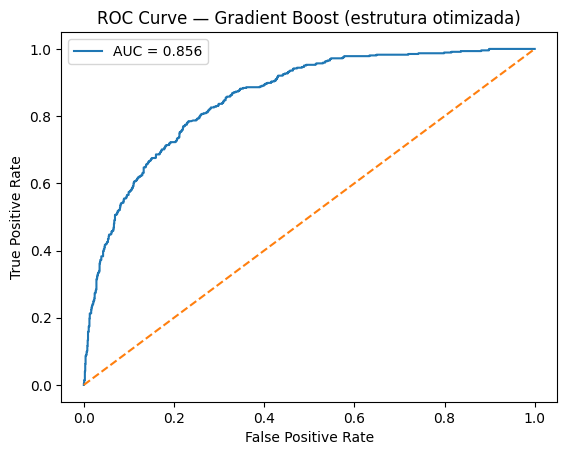

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Gradient Boost (estrutura otimizada)")
plt.legend()
plt.show()


KS (GB — estrutura otimizada): 0.5528


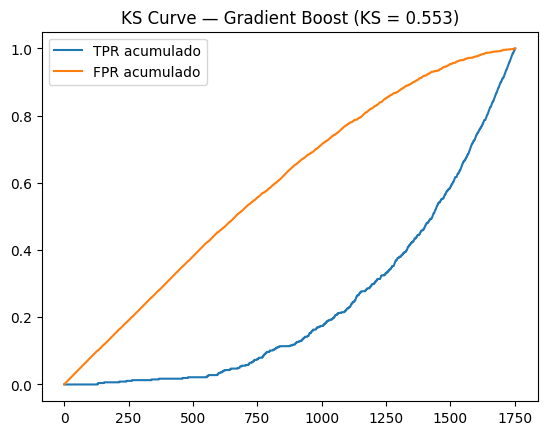

In [ ]:
ks = ks_statistic(y_test_true, p_test_struct)
print(f"KS (GB — estrutura otimizada): {ks:.4f}")

order = np.argsort(p_test_struct)
y_sorted = y_test_true[order]

cum_pos = np.cumsum(y_sorted) / np.sum(y_sorted)
cum_neg = np.cumsum(1 - y_sorted) / np.sum(1 - y_sorted)

plt.figure()
plt.plot(cum_pos, label="TPR acumulado")
plt.plot(cum_neg, label="FPR acumulado")
plt.title(f"KS Curve — Gradient Boost (KS = {ks:.3f})")
plt.legend()
plt.show()



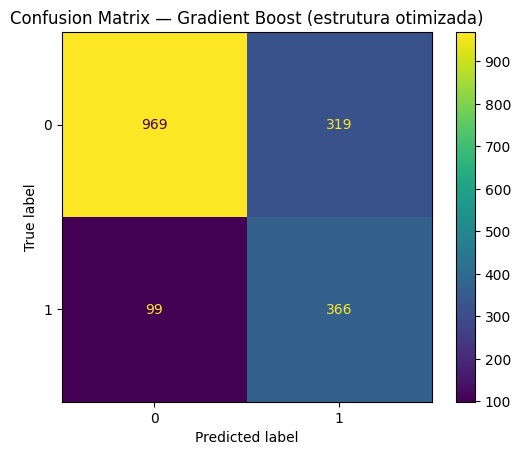

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (p_test_struct >= 0.5).astype(int)

cm = confusion_matrix(y_test_true, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix — Gradient Boost (estrutura otimizada)")
plt.show()


## Variando taxas de aprendizado

In [ ]:
def objective_gb_lr(trial):

    lr = trial.suggest_float("learning_rate", 0.005, 0.2, log=True)

    model = GradientBoostingClassifier(
        **BEST_GB_STRUCT,
        learning_rate=lr,
        random_state=42
    )

    model.fit(X_train_over, y_train_over)

    p_val = model.predict_proba(X_val_over)[:, 1]

    return ks_statistic(y_val_over, p_val)


In [ ]:
study_gb_lr = optuna.create_study(direction="maximize")
study_gb_lr.optimize(objective_gb_lr, n_trials=20)

BEST_GB_LR = study_gb_lr.best_params
print("Melhor learning rate:", BEST_GB_LR)


[I 2025-12-19 03:55:39,620] A new study created in memory with name: no-name-67be85cf-a069-4ac0-9ca5-c9a8371f7944
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-12-19 03:55:42,830] Trial 0 finished with value: 0.5566770186335404 and parameters: {'learning_rate': 0.008981596612187916}. Best is trial 0 with value: 0.5566770186335404.
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-12-19 03:55:45,511] Trial 1 finished with value: 0.5605590062111802 and parameters: {'learning_rate': 0.019874069966188956}. Best is trial 1 with value: 0.5605590062

Melhor learning rate: {'learning_rate': 0.023637223341180177}


In [ ]:
gb_final = GradientBoostingClassifier(
    **BEST_GB_STRUCT,
    learning_rate=BEST_GB_LR["learning_rate"],
    random_state=42
)

gb_final.fit(X_train_over, y_train_over)

p_test_final = gb_final.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


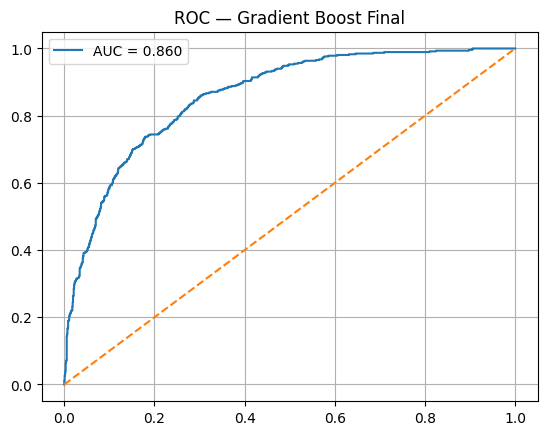

In [ ]:
fpr, tpr, _ = roc_curve(y_test, p_test_final)
auc = roc_auc_score(y_test, p_test_final)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.title("ROC — Gradient Boost Final")
plt.legend()
plt.grid()
plt.show()


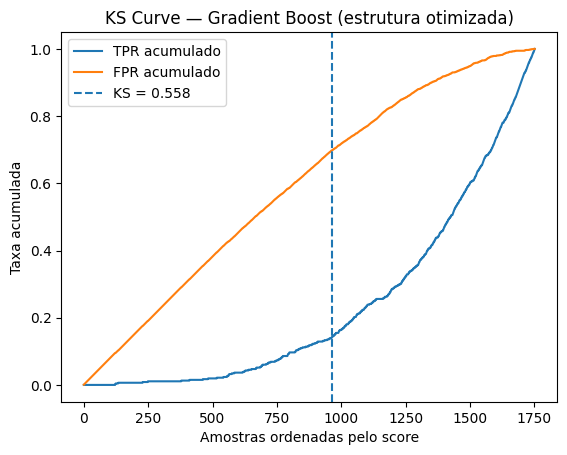

In [ ]:
order = np.argsort(p_test_final)
y_sorted = y_test_true[order]

cum_pos = np.cumsum(y_sorted) / np.sum(y_sorted)
cum_neg = np.cumsum(1 - y_sorted) / np.sum(1 - y_sorted)

ks_stat = np.max(np.abs(cum_pos - cum_neg))
ks_idx = np.argmax(np.abs(cum_pos - cum_neg))

plt.figure()
plt.plot(cum_pos, label="TPR acumulado")
plt.plot(cum_neg, label="FPR acumulado")
plt.axvline(ks_idx, linestyle="--", label=f"KS = {ks_stat:.3f}")
plt.xlabel("Amostras ordenadas pelo score")
plt.ylabel("Taxa acumulada")
plt.title("KS Curve — Gradient Boost (estrutura otimizada)")
plt.legend()
plt.show()


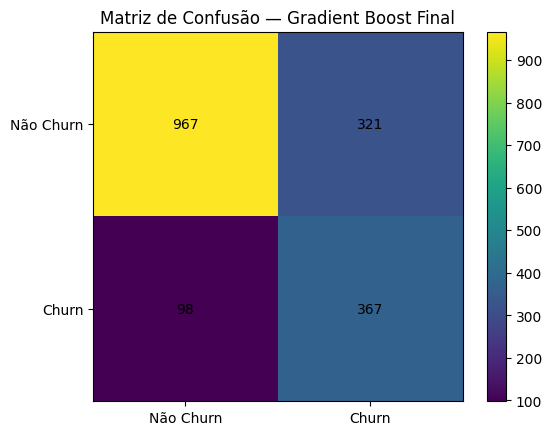

In [ ]:
y_pred = (p_test_final >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.colorbar()
plt.xticks([0, 1], ["Não Churn", "Churn"])
plt.yticks([0, 1], ["Não Churn", "Churn"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.title("Matriz de Confusão — Gradient Boost Final")
plt.show()
